<div align=center>

<font size=5>
    In the Name of God
<font/>
<br/>
<br/>
<font>
    Sharif University of Technology - Departmenet of Electrical Engineering
</font>
<br/>
<font>
    Introducing with Machine Learing - Dr. S. Amini
</font>
<br/>
<br/>
Spring 2023

</div>

<hr/>
<div align=center>
<font size=6>
    Neural Networks Practical Assignment
    
    Question 2
</font>
<br/>
<font size=4>
<br/>
</div>

# Personal Data

In [ ]:
# Set your student number
student_number = 99101246
Name = 'Danial'
Last_Name = 'Ayati'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- In this question, you are allowed to use `torch.optim`, `torch.nn` or any other submodule you need.
- You **are not allowed** to use the models already implemented or the pretrained models in torch.

In [1]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [2]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

You should load the train and test set of the `CIFAR10` dataset and apply the desired transforms on it. Then, you should create the loaders for these `test` and `train` sets.
- **Hint:** You can use `torchvision.datasets` to easily load the CIFAR10 dataset.

In [3]:
config = {
    'batch_size' : 64 ,
    'num_classes' : 10 ,
    'eopches' : 25 ,
    'learning_rate' : 0.0005
}

normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],)


train_transform1 = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,])



train_transform2 = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor(),
            normalize,])

test_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,])


#trainig set
all_datasets = []
train_data_aug1 = torchvision.datasets.CIFAR10(root='./content', train=True,
                                        download=True, transform=train_transform1)
all_datasets.append(train_data_aug1)


train_data_aug2 = torchvision.datasets.CIFAR10(root='./content', train=True,
                                        download=True, transform=train_transform2)
all_datasets.append(train_data_aug2)


train_data_total = torch.utils.data.ConcatDataset(all_datasets)
train_loader  = DataLoader(train_data_total, batch_size=config['batch_size'], shuffle=True, num_workers=1)

test_data = torchvision.datasets.CIFAR10(root='./content', train=False,
                                        download=True, transform=test_transform)
test_loader  = DataLoader(test_data, batch_size=config['batch_size'], shuffle=True, num_workers=1)

100%|██████████| 170498071/170498071 [00:13<00:00, 12923310.47it/s]


Extracting ./content/cifar-10-python.tar.gz to ./content
Files already downloaded and verified
Files already downloaded and verified


## Visualization

Visualize 1 random image from each class


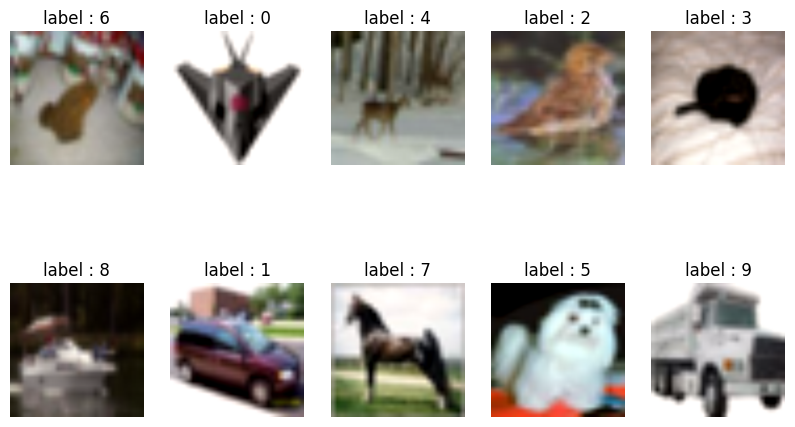

In [4]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
dict_={}
samples=[]
for i,(images,labels) in enumerate(test_loader):

     if(i==0):

        for index , label in enumerate(labels) :

            if len(dict_)==10 :
              break
            if int(label) not in dict_.keys():
               dict_[int(label)]=index
               samples.append(invTrans(images[index]))
            else :
              continue

     else :
      break


plt.figure(figsize=(10,6))
for  i,sample in enumerate(samples) :
     plt.subplot(2,5,i+1)
     sample =sample.permute(1, 2, 0)
     plt.imshow(sample)
     plt.title(f"label : {list(dict_)[i]}")
     plt.axis('off')

## Defining a Convolutional Neural Network

In this section, you should define a class called `Net` which represents the model for your convolutional neural network.
- **Hint:** You can use `torch.nn` to add the required layers to your model.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.LocalResponseNorm(2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16224, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, config['num_classes']))



    def forward(self, x):
        x = self.layer1(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

net = Net()

## Define a Loss function and optimizer

In this section, you simply define your loss function and optimizer.
- **Hint:** You can use `torch.optim` and implemented loss functions in torch.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)

## Training the model

You should train your model for multiple epochs. You are free to choose the number of epochs. However, you should reach an acceptable accuracy at the end.

In [7]:
def acc_cal(output_vec,label_vec,k=1):

    batch_size=label_vec.size(0)
    _,predicted=output_vec.topk(k,1,True,True)
    predicted=predicted.t()
    corrected_mat=predicted.eq(label_vec.reshape(1,-1).expand_as(predicted))

    correct_k = corrected_mat[:k].reshape(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(100.0 / batch_size)


steps_in_each_epoch=len(train_loader)
epoch_nums = 25
for epoch in range(epoch_nums):

    sum_of_loss=0
    running_loss = 0.0
    sum_acc1=0
    for i, (images,labels) in enumerate(train_loader, 0):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        acc_top1=acc_cal(outputs,labels,1)
        sum_acc1+=float(acc_top1)
        loss = criterion(outputs, labels)
        sum_of_loss+=float(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_of_each_epoch=float(sum_of_loss/steps_in_each_epoch)

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, config['eopches'], i+1, steps_in_each_epoch ,loss_of_each_epoch))

    print('Acc@1 of train_set: {} %'.format(sum_acc1 / steps_in_each_epoch ))

print('Finished Training')

Epoch [1/25], Step [1563/1563], Loss: 1.5701
Acc@1 of train_set: 44.66070857325656 %
Epoch [2/25], Step [1563/1563], Loss: 1.2614
Acc@1 of train_set: 55.75215930902111 %
Epoch [3/25], Step [1563/1563], Loss: 1.1557
Acc@1 of train_set: 59.448976327575174 %
Epoch [4/25], Step [1563/1563], Loss: 1.0790
Acc@1 of train_set: 62.45801343570058 %
Epoch [5/25], Step [1563/1563], Loss: 1.0167
Acc@1 of train_set: 64.56034069097889 %
Epoch [6/25], Step [1563/1563], Loss: 0.9587
Acc@1 of train_set: 66.56269993602048 %
Epoch [7/25], Step [1563/1563], Loss: 0.9078
Acc@1 of train_set: 68.41910588611644 %
Epoch [8/25], Step [1563/1563], Loss: 0.8647
Acc@1 of train_set: 69.9156269993602 %
Epoch [9/25], Step [1563/1563], Loss: 0.8189
Acc@1 of train_set: 71.58109404990402 %
Epoch [10/25], Step [1563/1563], Loss: 0.7783
Acc@1 of train_set: 72.96265195137556 %
Epoch [11/25], Step [1563/1563], Loss: 0.7370
Acc@1 of train_set: 74.50715770953295 %
Epoch [12/25], Step [1563/1563], Loss: 0.6972
Acc@1 of train_se

## Test the network on the test data

In the following section, you should test your network and calculate the accuracy of your model on the test dataset.

In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    acc1=0
    steps=len(test_loader)
    for (images,labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        acc_top1=acc_cal(outputs,labels,1)
        acc1+=float(acc_top1)

print(f'Accuracy of the network on the 10000 test images: {acc1 / steps} %')

Accuracy of the network on the 10000 test images: 70.59116242038216 %


Here, we also calculate the model performance for each class as well.

In [11]:
# prepare to count predictions for each class
classes =[0,1,2,3,4,5,6,7,8,9]
correct_pred = {f"class{classname}": 0 for classname in classes}
total_pred = {f"class{classname}": 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for (images,labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        labels=np.array(labels.cpu())
        pred_vec=np.array(outputs.argmax(dim=-1).cpu())

        for i,label in enumerate(labels) :
            total_pred[f"class{label}"]+=1
            if(label==pred_vec[i]):
              correct_pred[f"class{label}"]+=1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: class0 is 72.4 %
Accuracy for class: class1 is 75.6 %
Accuracy for class: class2 is 60.2 %
Accuracy for class: class3 is 53.2 %
Accuracy for class: class4 is 62.9 %
Accuracy for class: class5 is 58.4 %
Accuracy for class: class6 is 79.2 %
Accuracy for class: class7 is 76.2 %
Accuracy for class: class8 is 85.6 %
Accuracy for class: class9 is 77.2 %
